In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils as ut
from scipy.sparse.linalg import svds
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#%load_ext autoreload
#%autoreload 2

In [2]:
#movies = pd.read_csv('ml-latest-small/movies.csv')  # movieId title genres
#ratings = pd.read_csv('ml-latest-small/ratings.csv')  # userId movieId rating timestamp
#ratings.drop(['timestamp'], axis=1, inplace=True)  # we don't care about timestap so lets get rid of it

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv', 
                        usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})

ratings = pd.read_csv('ml-latest-small/ratings.csv',
                        usecols=['userId', 'movieId', 'rating'],
                        dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

In [4]:
movie_features = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [5]:
movie_features.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Let's split into training & test:
# user_title.shape : 610, 9719 (userId, title)
nUsers = movie_features.shape[0]
np.random.seed(0)
msk = np.random.rand(len(movie_features)) < 0.8

train = movie_features[msk]
test = movie_features[~msk]

## Train Data

In [7]:
#R = movie_features.to_numpy()
#user_ratings_mean = np.mean(R, axis=1)
#R_demeaned = R - user_ratings_mean.reshape(-1,1)
R_train = train.to_numpy()
user_ratings_mean = np.mean(R_train, axis=1)
R_train_demeaned = R_train - user_ratings_mean.reshape(-1,1)

In [53]:
U, sigma, Vt = svds(R_train_demeaned, k=50)
sigma = np.diag(sigma)

In [9]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
predictions = pd.DataFrame(all_user_predicted_ratings, columns=movie_features.columns)
predictions.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.281099,0.185364,1.559215,-0.038143,-0.659313,3.448722,-0.792422,-0.022066,0.310433,0.993166,...,-0.009400,-0.007368,-0.011431,-0.011431,-0.009400,-0.011431,-0.009400,-0.009400,-0.009400,-0.087194
1,-0.070009,0.067724,0.028907,0.040375,0.196385,-0.042833,0.099175,0.033795,0.024777,-0.095286,...,0.020840,0.018219,0.023461,0.023461,0.020840,0.023461,0.020840,0.020840,0.020840,0.037953
2,0.013115,-0.022256,0.039381,0.008511,-0.018636,0.137738,-0.015861,-0.002259,-0.002892,-0.053521,...,0.005363,0.005616,0.005111,0.005111,0.005363,0.005111,0.005363,0.005363,0.005363,0.009082
3,2.655516,-0.278274,0.090812,0.051195,0.322272,0.754654,0.621953,0.035179,0.047554,-0.016072,...,0.012614,0.010467,0.014760,0.014760,0.012614,0.014760,0.012614,0.012614,0.012614,-0.032565
4,1.541296,0.619044,0.003187,0.123471,0.298259,0.551892,0.289411,0.129671,-0.085306,1.045771,...,-0.004290,-0.003735,-0.004845,-0.004845,-0.004290,-0.004845,-0.004290,-0.004290,-0.004290,0.002572


In [10]:
train_pr, train_p = ut.recommend(330, predictions, movies, ratings)

In [11]:
train_pr.head()

,userId,movieId,rating,title
246,330,79702,5.0,Scott Pilgrim vs. the World (2010)
155,330,2324,5.0,Life Is Beautiful (La Vita è bella) (1997)
208,330,4886,5.0,"Monsters, Inc. (2001)"
204,330,4226,5.0,Memento (2000)
202,330,4022,5.0,Cast Away (2000)


In [12]:
train_p.head()

,movieId,title,prediction
6504,59315,Iron Man (2008),1.253278
4200,6539,Pirates of the Caribbean: The Curse of the Bla...,1.195548
6796,68954,Up (2009),1.077894
7521,91529,"Dark Knight Rises, The (2012)",1.007403
6296,54286,"Bourne Ultimatum, The (2007)",0.940601


## Test Data

In [13]:
R_test = test.to_numpy()
user_ratings_mean = np.mean(R_test, axis=1)
R_test_demeaned = R_test - user_ratings_mean.reshape(-1,1)

U, sigma, Vt = svds(R_test_demeaned, k=50)
sigma = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
predictions = pd.DataFrame(all_user_predicted_ratings, columns=movie_features.columns)
predictions.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,0.402321,1.442578,0.188847,0.096837,0.507893,0.487932,0.530328,-0.006014,0.113002,1.892592,...,-0.002934,-0.002934,-0.002934,-0.002934,-0.002934,-0.002934,-0.002934,-0.002934,-0.002934,-0.002934
1,0.184181,0.466375,-0.025407,0.027588,-0.063257,0.000717,-0.233497,0.006319,-0.050982,-0.078062,...,0.002469,0.002469,0.002469,0.002469,0.002469,0.002469,0.002469,0.002469,0.002469,0.002469
2,0.690254,1.015502,0.214907,0.099752,0.456138,0.480382,0.629200,-0.033442,0.070274,1.189408,...,0.003042,0.003042,0.003042,0.003042,0.003042,0.003042,0.003042,0.003042,0.003042,0.003042
3,3.494950,3.057709,-0.014504,0.001364,0.062403,4.062497,-0.018771,-0.000499,0.031491,-0.072015,...,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077,0.000077
4,0.162347,2.953009,0.133067,-0.056717,0.026417,-0.171451,-0.029165,0.969604,-0.001989,-0.073457,...,0.000879,0.000879,0.000879,0.000879,0.000879,0.000879,0.000879,0.000879,0.000879,0.000879


In [14]:
test_pr, test_p = ut.recommend(5, predictions, movies, ratings)

In [15]:
test_pr.head()

,userId,movieId,rating,title
37,5,590,5.0,Dances with Wolves (1990)
30,5,475,5.0,In the Name of the Father (1993)
32,5,527,5.0,Schindler's List (1993)
6,5,58,5.0,"Postman, The (Postino, Il) (1994)"
41,5,596,5.0,Pinocchio (1940)


In [16]:
test_p.head()

,movieId,title,prediction
3596,4995,"Beautiful Mind, A (2001)",5.749630
4093,5952,"Lord of the Rings: The Two Towers, The (2002)",5.489252
1346,1907,Mulan (1998),5.383203
1501,2081,"Little Mermaid, The (1989)",5.344841
39,48,Pocahontas (1995),5.314695


## Applying PCA For Dimensionality Reduction 

We want to standardize our data so that the mean of observed values is 0 and the standard deviation is 1. We will do this using scikit-learn object StandardScalar. 

In [17]:
# converts to a range between 0 and 1
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train)

With our standardized data, we can create a covariance matrix that represents the covariance between each feature in our data.

In [18]:
cov_matrix = np.cov(scaled_train)

We can then take the eigendecomposition of the covariance matrix to get the principal components.

In [19]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)

Plotting the explained variance and cumulative explained variance helps us determine how many components to use.

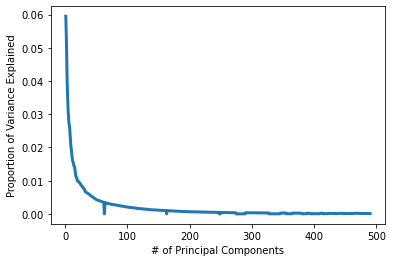

In [20]:
var_explained = []

for i in eigen_values:
    var_explained.append((i/sum(eigen_values)))


plt.plot(range(1,491), var_explained, lw=3)
plt.ylabel('Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

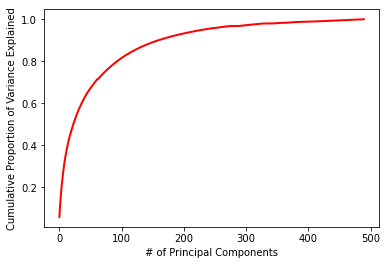

In [21]:
cum_var_explained = np.cumsum(var_explained)

plt.plot(range(490), cum_var_explained, 'r-', lw=2)
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.xlabel('# of Principal Components')

plt.show()

Apply the K components to the original standardized data where K is the number of components chosen. We chose K = 200 because it explains about 90% of the variance in the data set.

## Train

In [22]:
U, sigma, Vt = svds(R_train_demeaned, k=50)
sigma = np.diag(sigma)

In [54]:
W = U.dot(sigma)
X0_train = W[:,:200].dot(Vt[:200])

MSE = np.mean( (R_train_demeaned - X0_train) ** 2 )
print('MSE =', MSE)

X_train = scaler.inverse_transform(X0_train)

MSE = 0.0865581


In [25]:
#all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
predictions = pd.DataFrame(X_train, columns=movie_features.columns)
predictions.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,5.561592,0.707869,1.802499,-0.011713,-0.435397,5.896101,-0.553909,-0.006943,0.212668,2.038286,...,-0.010796,-0.008979,-0.012705,-0.012705,-0.010796,-0.012705,-0.010796,-0.010796,-0.010796,-0.026382
1,1.200248,0.673400,0.331810,0.031765,0.420800,0.604790,0.342925,0.046750,0.103278,0.568557,...,0.008575,0.006995,0.010273,0.010273,0.008575,0.010273,0.008575,0.008575,0.008575,0.012889
2,1.364625,0.553171,0.344572,0.024170,0.228429,0.888997,0.239905,0.034419,0.088752,0.633142,...,0.006447,0.005560,0.007322,0.007322,0.006447,0.007322,0.006447,0.006447,0.006447,0.008039
3,6.333196,0.108706,0.326390,0.017422,0.473799,1.741576,0.758145,0.022913,0.078131,0.586280,...,-0.003340,-0.003153,-0.003430,-0.003430,-0.003340,-0.003430,-0.003340,-0.003340,-0.003340,-0.011972
4,4.302478,1.420448,0.300717,0.051712,0.508575,1.523284,0.512046,0.079776,0.038319,2.245341,...,0.003866,0.003389,0.004318,0.004318,0.003866,0.004318,0.003866,0.003866,0.003866,0.005657


In [26]:
train_pca_pr, train_pca_p = ut.recommend(330, predictions, movies, ratings)

In [27]:
train_pca_pr.head()

,userId,movieId,rating,title
246,330,79702,5.0,Scott Pilgrim vs. the World (2010)
155,330,2324,5.0,Life Is Beautiful (La Vita è bella) (1997)
208,330,4886,5.0,"Monsters, Inc. (2001)"
204,330,4226,5.0,Memento (2000)
202,330,4022,5.0,Cast Away (2000)


In [28]:
train_pca_p.head()

,movieId,title,prediction
408,527,Schindler's List (1993),3.419256
4200,6539,Pirates of the Caribbean: The Curse of the Bla...,2.807550
707,1036,Die Hard (1988),2.372220
6796,68954,Up (2009),2.359532
6504,59315,Iron Man (2008),2.323858


## Test

In [55]:
U, sigma, Vt = svds(R_test_demeaned, k=50)
sigma = np.diag(sigma)

W = U.dot(sigma)
X0_test = W[:,:200].dot(Vt[:200])

MSE = np.mean( (R_test_demeaned - X0_test) ** 2 )
print('MSE =', MSE)

X_test = scaler.inverse_transform(X0)

MSE = 0.028130507


In [39]:
#all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1,1)
predictions = pd.DataFrame(X_test, columns=movie_features.columns)
predictions.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.101661,2.544804,0.489768,0.044728,0.697146,1.422441,0.730870,0.030341,0.150102,3.493650,...,0.003950,0.003386,0.004515,0.004515,0.003950,0.004515,0.003950,0.003950,0.003950,0.004515
1,1.684021,1.213213,0.272519,0.027584,0.183026,0.666910,0.036392,0.035477,0.058330,0.588587,...,0.005096,0.004368,0.005824,0.005824,0.005096,0.005824,0.005096,0.005096,0.005096,0.005824
2,2.658589,1.961830,0.516945,0.045600,0.650868,1.411495,0.821458,0.020595,0.126207,2.456846,...,0.004976,0.004265,0.005686,0.005686,0.004976,0.005686,0.004976,0.004976,0.004976,0.005686
3,7.734513,4.512347,0.102391,-0.024172,0.136442,6.713765,0.070561,-0.031179,0.004689,0.335966,...,-0.023277,-0.019952,-0.026603,-0.026603,-0.023277,-0.026603,-0.023277,-0.023277,-0.023277,-0.026603
4,1.499085,4.510448,0.358986,-0.012670,0.197234,0.283797,0.155237,0.357550,0.044209,0.486280,...,-0.006834,-0.005858,-0.007810,-0.007810,-0.006834,-0.007810,-0.006834,-0.006834,-0.006834,-0.007810


In [40]:
test_pca_pr, test_pca_p = ut.recommend(5, predictions, movies, ratings)

In [41]:
test_pca_pr.head()

,userId,movieId,rating,title
37,5,590,5.0,Dances with Wolves (1990)
30,5,475,5.0,In the Name of the Father (1993)
32,5,527,5.0,Schindler's List (1993)
6,5,58,5.0,"Postman, The (Postino, Il) (1994)"
41,5,596,5.0,Pinocchio (1940)


In [42]:
test_pca_p.head()

,movieId,title,prediction
4093,5952,"Lord of the Rings: The Two Towers, The (2002)",11.340885
3594,4993,"Lord of the Rings: The Fellowship of the Ring,...",10.971720
3596,4995,"Beautiful Mind, A (2001)",9.772295
3150,4306,Shrek (2001),9.598457
2630,3578,Gladiator (2000),9.385555


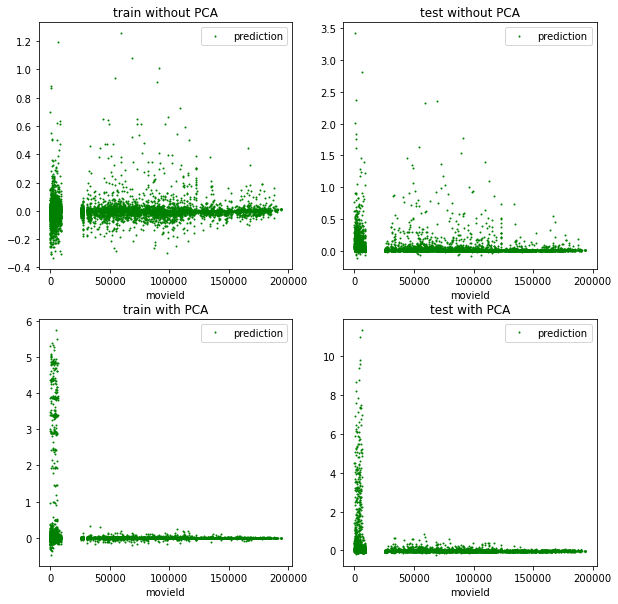

In [43]:
df_list = [train_p, test_p, train_pca_p, test_pca_p]
titles = ['train without PCA', 'test without PCA', 'train with PCA', 'test with PCA']
fig, axs = plt.subplots(2, 2,figsize=(10,10))
index = 0
for i in range(2):
    for j in range(2):
        df_list[index].plot(ax=axs[j,i], x='movieId', y='prediction', style='o', markersize=1, c='g')
        axs[i,j].set_title(titles[index])
        index += 1
#axs[0,0].train_pca_p.plot(x='movieId', y='prediction', style='o', markersize=1)